/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Extracting HOG features...

Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.81      0.87       270
           2       0.79      0.70      0.74       253
           3       0.66      0.71      0.68       236
           4       0.62      0.63      0.63       197
           5       0.60      0.86      0.71       112

    accuracy                           0.73      1068
   macro avg       0.72      0.74      0.73      1068
weighted avg       0.75      0.73      0.74      1068



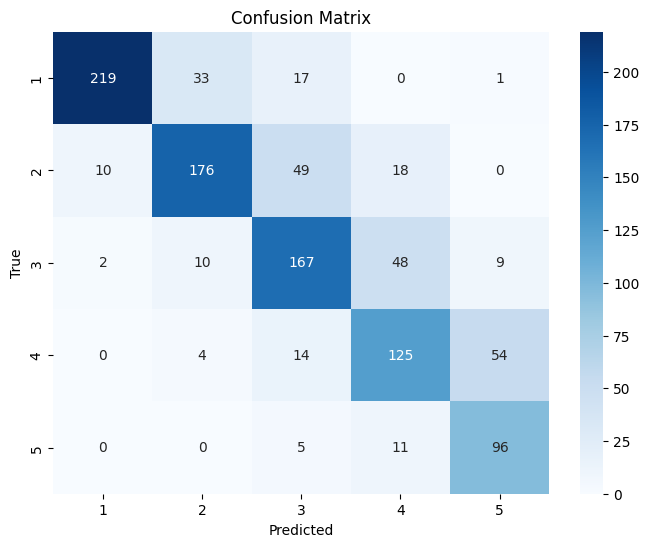

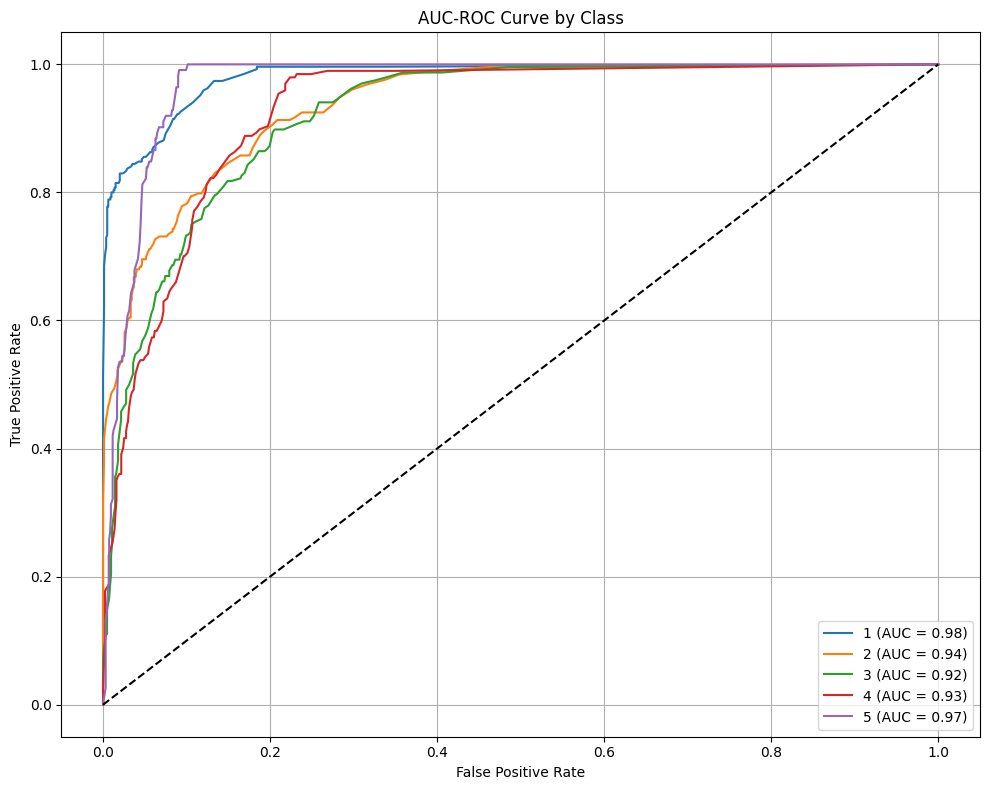


F1 Scores per class:
1: 0.87
2: 0.74
3: 0.68
4: 0.63
5: 0.71

Mean Average Precision (mAP): 0.8025


In [2]:
#hog random forest
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, average_precision_score
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import albumentations as A

# Paths
train_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/train/images'
val_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/val/images'
test_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/test/images'

IMG_SIZE = 128

augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomGamma(p=0.3),
    A.MotionBlur(p=0.3),
    A.CLAHE(p=0.2),
    A.GaussNoise(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.GridDistortion(p=0.2)
])

# Load data
def load_data_from_folder(folder):
    image_paths = glob(os.path.join(folder, '*.jpg'))
    images, labels = [], []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = path.split("_")[-2]
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

X_train, y_train = load_data_from_folder(train_img_dir)
X_val, y_val = load_data_from_folder(val_img_dir)
X_test, y_test = load_data_from_folder(test_img_dir)

# Label Encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Augment minority classes
def augment_minority_classes(X, y, augment, le):
    counts = Counter(y)
    max_count = max(counts.values())
    new_X, new_y = list(X), list(y)
    for label in counts:
        imgs = [img for img, lbl in zip(X, y) if lbl == label]
        for _ in range(max_count - counts[label]):
            img = imgs[np.random.randint(len(imgs))]
            aug_img = augment(image=img)['image']
            new_X.append(aug_img)
            new_y.append(label)
    return np.array(new_X), np.array(new_y)

X_train_aug, y_train_aug = augment_minority_classes(X_train, y_train, augment, le)

# HOG feature extraction
def extract_hog_features(images):
    hog_features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

print("Extracting HOG features...")
X_train_hog = extract_hog_features(X_train_aug)
X_test_hog = extract_hog_features(X_test)

y_train_hog_encoded = le.transform(y_train_aug)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_hog, y_train_hog_encoded)

# Predict
y_pred = rf.predict(X_test_hog)
y_pred_proba = rf.predict_proba(X_test_hog)

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_encoded, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve per class
plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve((y_test_encoded == i).astype(int), y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("AUC-ROC Curve by Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# F1 Scores per class
print("\nF1 Scores per class:")
for i, cls in enumerate(le.classes_):
    f1 = f1_score((y_test_encoded == i).astype(int), (y_pred == i).astype(int))
    print(f"{cls}: {f1:.2f}")

# mAP
map_score = average_precision_score(
    np.eye(len(le.classes_))[y_test_encoded], y_pred_proba, average='macro')
print(f"\nMean Average Precision (mAP): {map_score:.4f}")



Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.81      0.87       270
           2       0.79      0.70      0.74       253
           3       0.68      0.72      0.70       236
           4       0.62      0.64      0.63       197
           5       0.59      0.85      0.70       112

    accuracy                           0.74      1068
   macro avg       0.73      0.74      0.73      1068
weighted avg       0.75      0.74      0.74      1068



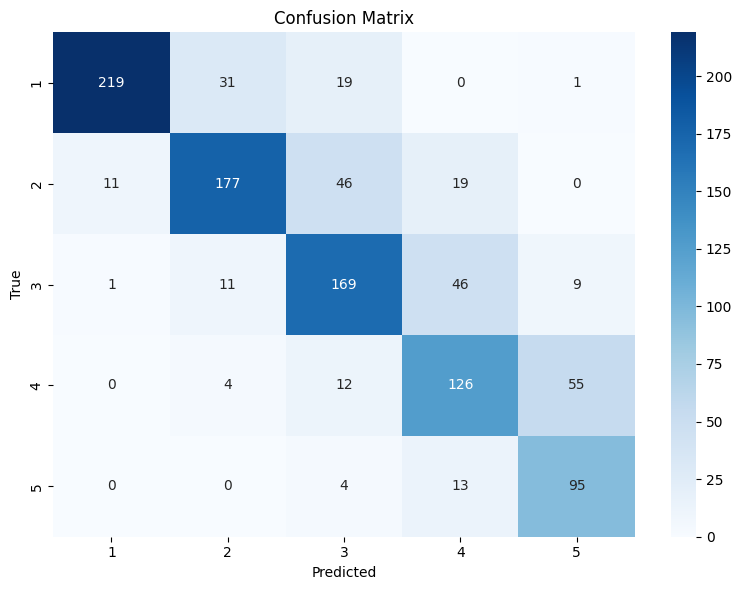

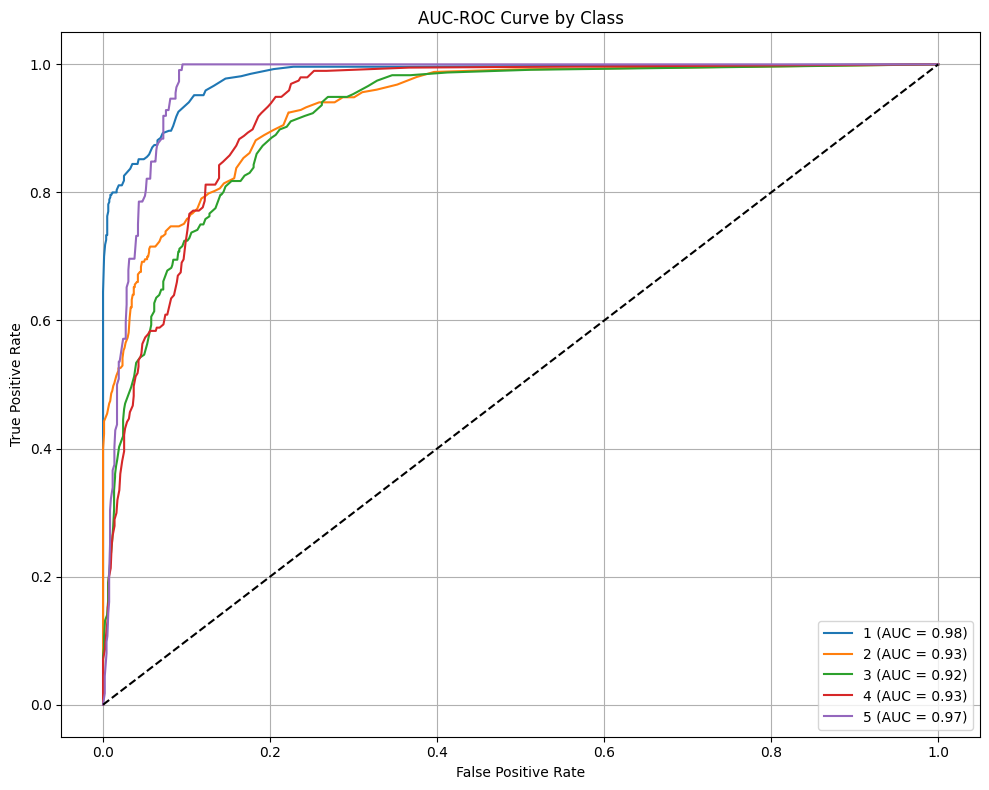


F1 Scores:
1: 0.87
2: 0.74
3: 0.70
4: 0.63
5: 0.70

Mean Average Precision (mAP):
mAP: 0.7998


In [3]:
# Notebook 1: Random Forest Classifier with Full Feature Set

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, average_precision_score
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
import albumentations as A

# Configuration
IMG_SIZE = 128
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS

augment = A.Compose([
    A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5), A.RandomGamma(p=0.3), A.MotionBlur(p=0.3),
    A.CLAHE(p=0.2), A.GaussNoise(p=0.3), A.HueSaturationValue(p=0.3), A.GridDistortion(p=0.2)
])

# Load data
def load_data_from_folder(folder):
    image_paths = glob(os.path.join(folder, '*.jpg'))
    images, labels = [], []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = path.split("_")[-2]
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

train_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/train/images'
val_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/val/images'
test_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/test/images'

X_train, y_train = load_data_from_folder(train_img_dir)
X_test, y_test = load_data_from_folder(test_img_dir)

# Balance minority classes
def augment_minority_classes(X, y, augment):
    counts = Counter(y)
    max_count = max(counts.values())
    new_X, new_y = list(X), list(y)
    for label in counts:
        imgs = [img for img, lbl in zip(X, y) if lbl == label]
        for _ in range(max_count - counts[label]):
            img = imgs[np.random.randint(len(imgs))]
            aug_img = augment(image=img)['image']
            new_X.append(aug_img)
            new_y.append(label)
    return np.array(new_X), np.array(new_y)

X_train_aug, y_train_aug = augment_minority_classes(X_train, y_train, augment)

# Feature Extraction

def extract_features(images):
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # HOG
        hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)

        # LBP
        lbp = local_binary_pattern(gray, P=LBP_POINTS, R=LBP_RADIUS, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3),
                                   range=(0, LBP_POINTS + 2), density=True)

        # GLCM
        glcm = graycomatrix((gray / 4).astype(np.uint8), distances=[1], angles=[0], symmetric=True, normed=True)
        glcm_props = [graycoprops(glcm, prop).ravel()[0] for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']]

        # Hu Moments
        hu = cv2.HuMoments(cv2.moments(gray)).flatten()

        # Sobel
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel_stats = [np.mean(sobelx), np.std(sobelx), np.mean(sobely), np.std(sobely)]

        # Color Histogram
        color_hist = []
        for i in range(3):
            hist = cv2.calcHist([img], [i], None, [32], [0, 256]).flatten()
            color_hist.extend(hist / hist.sum())

        # Contour-based Shape
        contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            c = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(c)
            aspect_ratio = float(w)/h
            area = cv2.contourArea(c)
            hull = cv2.convexHull(c)
            hull_area = cv2.contourArea(hull)
            solidity = float(area) / hull_area if hull_area > 0 else 0
        else:
            aspect_ratio, solidity = 0, 0

        feature_vector = np.hstack([hog_feat, lbp_hist, glcm_props, hu, sobel_stats, color_hist, [aspect_ratio, solidity]])
        features.append(feature_vector)
    return np.array(features)

X_train_feat = extract_features(X_train_aug)
X_test_feat = extract_features(X_test)

# Encode Labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_aug)
y_test_enc = le.transform(y_test)

# Train Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_feat, y_train_enc)

# Predict
preds = rf.predict(X_test_feat)
probs = rf.predict_proba(X_test_feat)

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test_enc, preds, target_names=le.classes_))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_enc, preds), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve((y_test_enc == i).astype(int), probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("AUC-ROC Curve by Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nF1 Scores:")
for i, cls in enumerate(le.classes_):
    print(f"{cls}: {f1_score((y_test_enc == i).astype(int), (preds == i).astype(int)):.2f}")

print("\nMean Average Precision (mAP):")
print(f"mAP: {average_precision_score(np.eye(len(le.classes_))[y_test_enc], probs, average='macro'):.4f}")



Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.81      0.87       270
           2       0.78      0.70      0.73       253
           3       0.66      0.71      0.68       236
           4       0.64      0.66      0.65       197
           5       0.62      0.83      0.71       112

    accuracy                           0.74      1068
   macro avg       0.73      0.74      0.73      1068
weighted avg       0.75      0.74      0.74      1068



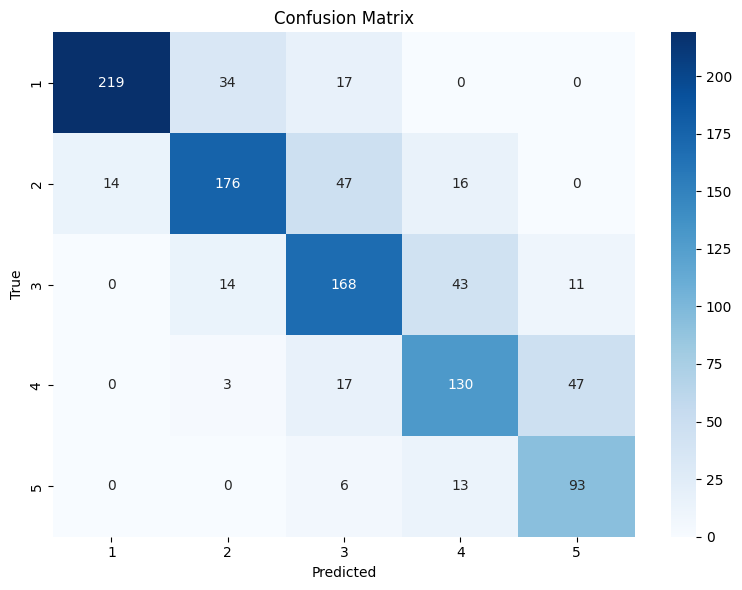

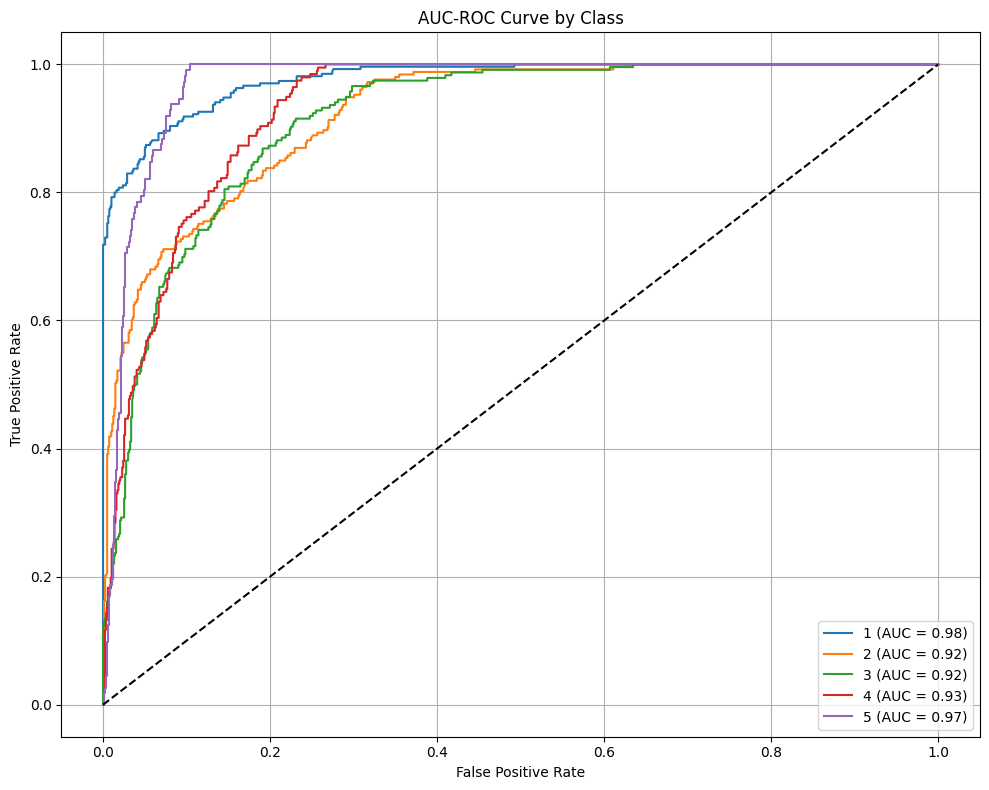


F1 Scores:
1: 0.87
2: 0.73
3: 0.68
4: 0.65
5: 0.71

Mean Average Precision (mAP):
mAP: 0.7826


In [4]:
#xg boost
# Let's generate a complete and fixed version of the XGBoost classifier implementation
# using the same feature extraction as before: HOG, LBP, GLCM, Hu Moments, Sobel, Color Histogram, and Shape Descriptors.

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, average_precision_score
from xgboost import XGBClassifier
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
import albumentations as A

# Configuration
IMG_SIZE = 128
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS

augment = A.Compose([
    A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5), A.RandomGamma(p=0.3), A.MotionBlur(p=0.3),
    A.CLAHE(p=0.2), A.GaussNoise(p=0.3), A.HueSaturationValue(p=0.3), A.GridDistortion(p=0.2)
])

# Load data
def load_data_from_folder(folder):
    image_paths = glob(os.path.join(folder, '*.jpg'))
    images, labels = [], []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = path.split("_")[-2]
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Sample Paths (adjust based on real environment)
train_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/train/images'
test_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/test/images'

X_train, y_train = load_data_from_folder(train_img_dir)
X_test, y_test = load_data_from_folder(test_img_dir)

# Balance minority classes
def augment_minority_classes(X, y, augment):
    counts = Counter(y)
    max_count = max(counts.values())
    new_X, new_y = list(X), list(y)
    for label in counts:
        imgs = [img for img, lbl in zip(X, y) if lbl == label]
        for _ in range(max_count - counts[label]):
            img = imgs[np.random.randint(len(imgs))]
            aug_img = augment(image=img)['image']
            new_X.append(aug_img)
            new_y.append(label)
    return np.array(new_X), np.array(new_y)

X_train_aug, y_train_aug = augment_minority_classes(X_train, y_train, augment)

# Feature Extraction
def extract_features(images):
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # HOG
        hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)

        # LBP
        lbp = local_binary_pattern(gray, P=LBP_POINTS, R=LBP_RADIUS, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3),
                                   range=(0, LBP_POINTS + 2), density=True)

        # GLCM
        glcm = graycomatrix((gray / 4).astype(np.uint8), distances=[1], angles=[0], symmetric=True, normed=True)
        glcm_props = [graycoprops(glcm, prop).ravel()[0] for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']]

        # Hu Moments
        hu = cv2.HuMoments(cv2.moments(gray)).flatten()

        # Sobel
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel_stats = [np.mean(sobelx), np.std(sobelx), np.mean(sobely), np.std(sobely)]

        # Color Histogram
        color_hist = []
        for i in range(3):
            hist = cv2.calcHist([img], [i], None, [32], [0, 256]).flatten()
            color_hist.extend(hist / hist.sum())

        # Contour-based Shape
        contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            c = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(c)
            aspect_ratio = float(w)/h
            area = cv2.contourArea(c)
            hull = cv2.convexHull(c)
            hull_area = cv2.contourArea(hull)
            solidity = float(area) / hull_area if hull_area > 0 else 0
        else:
            aspect_ratio, solidity = 0, 0

        feature_vector = np.hstack([hog_feat, lbp_hist, glcm_props, hu, sobel_stats, color_hist, [aspect_ratio, solidity]])
        features.append(feature_vector)
    return np.array(features)

X_train_feat = extract_features(X_train_aug)
X_test_feat = extract_features(X_test)

# Encode Labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_aug)
y_test_enc = le.transform(y_test)

# Train XGBoost Classifier
xgb = XGBClassifier(n_estimators=100, max_depth=6, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train_feat, y_train_enc)

# Predict
preds = xgb.predict(X_test_feat)
probs = xgb.predict_proba(X_test_feat)

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test_enc, preds, target_names=le.classes_))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_enc, preds), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve((y_test_enc == i).astype(int), probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("AUC-ROC Curve by Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nF1 Scores:")
for i, cls in enumerate(le.classes_):
    print(f"{cls}: {f1_score((y_test_enc == i).astype(int), (preds == i).astype(int)):.2f}")

print("\nMean Average Precision (mAP):")
print(f"mAP: {average_precision_score(np.eye(len(le.classes_))[y_test_enc], probs, average='macro'):.4f}")



/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Extracting features...

Classification Report:
              precision    recall  f1-score   support

           1       0.46      0.41      0.44       270
           2       0.43      0.48      0.45       253
           3       0.41      0.36      0.38       236
           4       0.32      0.31      0.32       197
           5       0.53      0.67      0.59       112

    accuracy                           0.43      1068
   macro avg       0.43      0.45      0.44      1068
weighted avg       0.42      0.43      0.42      1068



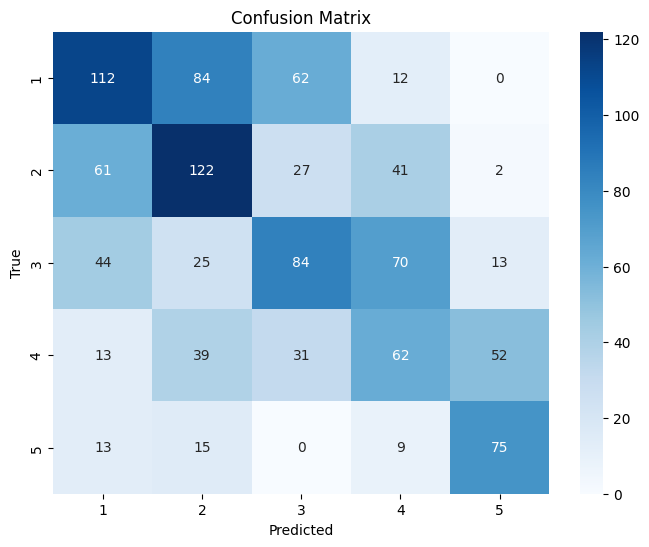

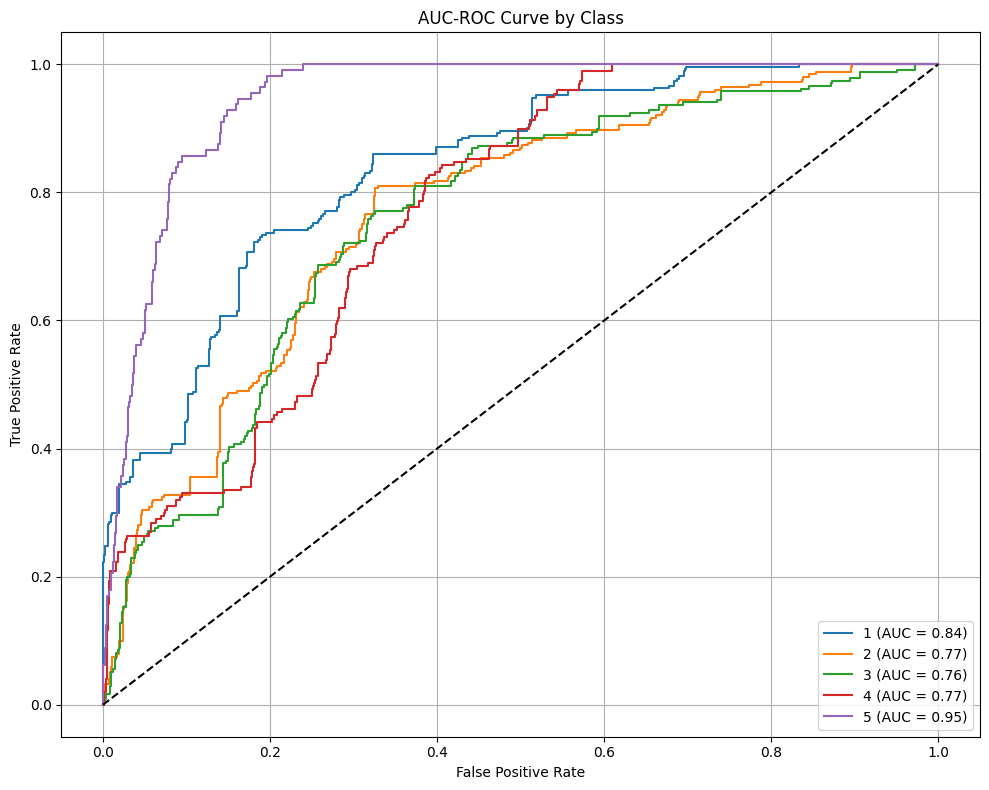


F1 Scores per class:
1: 0.44
2: 0.45
3: 0.38
4: 0.32
5: 0.59

Mean Average Precision (mAP): 0.5418


In [1]:
# ---------- Notebook 2: SVM Classifier ----------

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import Counter

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, average_precision_score
from sklearn.model_selection import train_test_split
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops

import albumentations as A

# ========== CONFIG ==========
IMG_SIZE = 128

augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomGamma(p=0.3),
    A.MotionBlur(p=0.3),
    A.CLAHE(p=0.2),
    A.GaussNoise(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.GridDistortion(p=0.2)
])

# ========== LOAD DATA ==========
def load_data(folder):
    paths = glob(os.path.join(folder, '*.jpg'))
    X, y = [], []
    for path in paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = path.split("_")[-2]
        X.append(img)
        y.append(label)
    return np.array(X), np.array(y)

train_dir = "/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/train/images"
test_dir = "/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/test/images"

X_train, y_train = load_data(train_dir)
X_test, y_test = load_data(test_dir)

# ========== AUGMENT MINORITY CLASSES ==========
def augment_minority_classes(X, y, augment):
    counts = Counter(y)
    max_count = max(counts.values())
    new_X, new_y = list(X), list(y)
    for label in counts:
        imgs = [img for img, lbl in zip(X, y) if lbl == label]
        for _ in range(max_count - counts[label]):
            img = imgs[np.random.randint(len(imgs))]
            aug_img = augment(image=img)['image']
            new_X.append(aug_img)
            new_y.append(label)
    return np.array(new_X), np.array(new_y)

X_train_aug, y_train_aug = augment_minority_classes(X_train, y_train, augment)

# ========== FEATURE EXTRACTION ==========
def extract_features(images):
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # HOG
        hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)

        # LBP
        lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
        lbp_hist = lbp_hist / np.sum(lbp_hist)

        # GLCM
        glcm = graycomatrix((gray / 4).astype('uint8'), distances=[1], angles=[0], levels=64, symmetric=True, normed=True)
        glcm_feat = [graycoprops(glcm, prop)[0, 0] for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']]

        # Hu Moments
        hu = cv2.HuMoments(cv2.moments(gray)).flatten()

        # Sobel
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3).flatten()
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3).flatten()
        sobel_feat = np.mean(sobelx), np.mean(sobely), np.std(sobelx), np.std(sobely)

        # Color histogram
        hist_r = cv2.calcHist([img], [0], None, [16], [0, 256]).flatten()
        hist_g = cv2.calcHist([img], [1], None, [16], [0, 256]).flatten()
        hist_b = cv2.calcHist([img], [2], None, [16], [0, 256]).flatten()
        hist_rgb = np.concatenate([hist_r, hist_g, hist_b]) / np.sum(hist_r + hist_g + hist_b)

        # Combine
        feat = np.concatenate([hog_feat, lbp_hist, glcm_feat, hu, sobel_feat, hist_rgb])
        features.append(feat)
    return np.array(features)

print("Extracting features...")
X_train_feat = extract_features(X_train_aug)
X_test_feat = extract_features(X_test)

# ========== ENCODING ==========
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_aug)
y_test_enc = le.transform(y_test)

# ========== TRAIN SVM ==========
from sklearn.svm import SVC
clf = SVC(probability=True, kernel='rbf')
clf.fit(X_train_feat, y_train_enc)

# ========== PREDICT & EVALUATE ==========
y_pred = clf.predict(X_test_feat)
y_pred_proba = clf.predict_proba(X_test_feat)

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_enc, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve((y_test_enc == i).astype(int), y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("AUC-ROC Curve by Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nF1 Scores per class:")
for i, cls in enumerate(le.classes_):
    f1 = f1_score((y_test_enc == i).astype(int), (y_pred == i).astype(int))
    print(f"{cls}: {f1:.2f}")

mAP = average_precision_score(np.eye(len(le.classes_))[y_test_enc], y_pred_proba, average='macro')
print(f"\nMean Average Precision (mAP): {mAP:.4f}")



Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.82      0.88       270
           2       0.80      0.71      0.75       253
           3       0.67      0.72      0.70       236
           4       0.63      0.61      0.62       197
           5       0.58      0.87      0.70       112

    accuracy                           0.74      1068
   macro avg       0.73      0.75      0.73      1068
weighted avg       0.76      0.74      0.74      1068



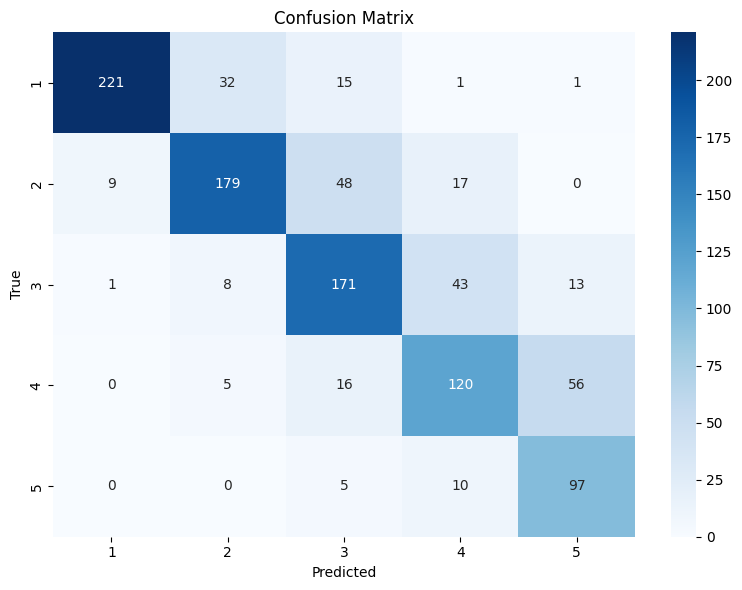

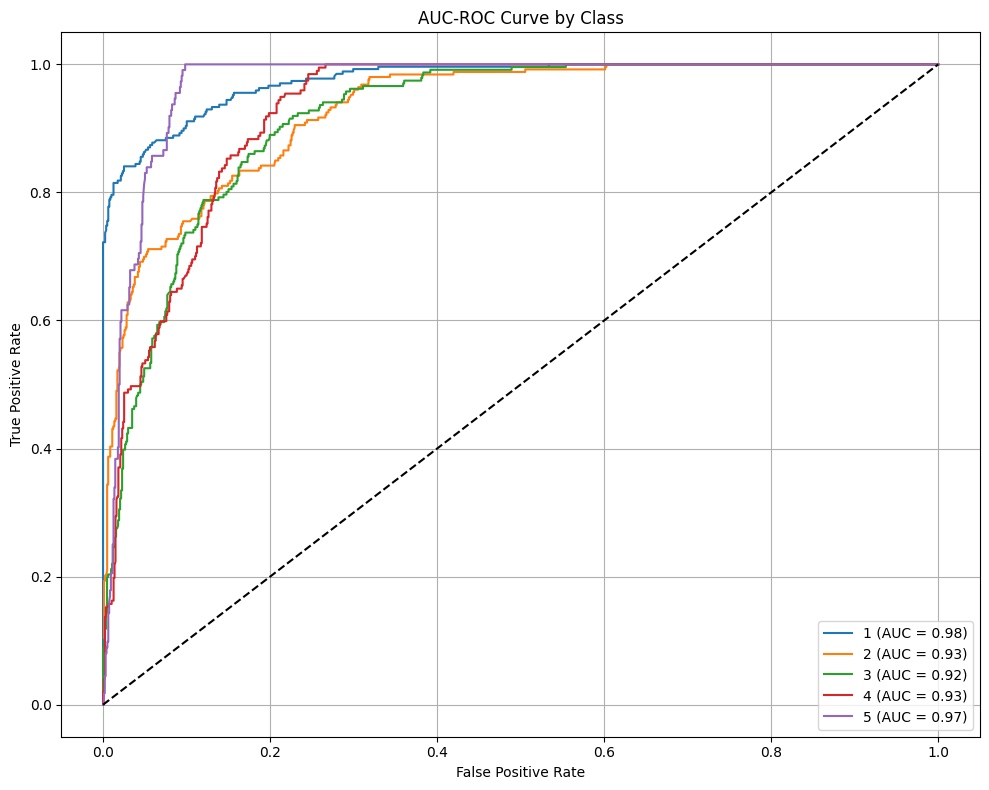


F1 Scores:
1: 0.88
2: 0.75
3: 0.70
4: 0.62
5: 0.70

Mean Average Precision (mAP):
mAP: 0.7848


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, average_precision_score
from xgboost import XGBClassifier
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import albumentations as A

# Configuration
IMG_SIZE = 128

augment = A.Compose([
    A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5), A.RandomGamma(p=0.3), A.MotionBlur(p=0.3),
    A.CLAHE(p=0.2), A.GaussNoise(p=0.3), A.HueSaturationValue(p=0.3), A.GridDistortion(p=0.2)
])

# Load data
def load_data_from_folder(folder):
    image_paths = glob(os.path.join(folder, '*.jpg'))
    images, labels = [], []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = path.split("_")[-2]
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Update with your paths
train_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/train/images'
test_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/test/images'

X_train, y_train = load_data_from_folder(train_img_dir)
X_test, y_test = load_data_from_folder(test_img_dir)

# Balance dataset
def augment_minority_classes(X, y, augment):
    counts = Counter(y)
    max_count = max(counts.values())
    new_X, new_y = list(X), list(y)
    for label in counts:
        imgs = [img for img, lbl in zip(X, y) if lbl == label]
        for _ in range(max_count - counts[label]):
            img = imgs[np.random.randint(len(imgs))]
            aug_img = augment(image=img)['image']
            new_X.append(aug_img)
            new_y.append(label)
    return np.array(new_X), np.array(new_y)

X_train_aug, y_train_aug = augment_minority_classes(X_train, y_train, augment)

# HOG Feature Extraction only
def extract_hog_features(images):
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        features.append(hog_feat)
    return np.array(features)

X_train_feat = extract_hog_features(X_train_aug)
X_test_feat = extract_hog_features(X_test)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_aug)
y_test_enc = le.transform(y_test)

# XGBoost Classifier
xgb = XGBClassifier(n_estimators=100, max_depth=6, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train_feat, y_train_enc)

# Predictions
preds = xgb.predict(X_test_feat)
probs = xgb.predict_proba(X_test_feat)

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test_enc, preds, target_names=le.classes_))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_enc, preds), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve((y_test_enc == i).astype(int), probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("AUC-ROC Curve by Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nF1 Scores:")
for i, cls in enumerate(le.classes_):
    print(f"{cls}: {f1_score((y_test_enc == i).astype(int), (preds == i).astype(int)):.2f}")

print("\nMean Average Precision (mAP):")
print(f"mAP: {average_precision_score(np.eye(len(le.classes_))[y_test_enc], probs, average='macro'):.4f}")


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Loading training data...
Loading test data...
Augmenting minority classes...
Final class distribution: {'3': 2159, '4': 2159, '1': 2159, '2': 2159, '5': 2159}

📄 Classification Report:

              precision    recall  f1-score   support

           1       0.93      0.79      0.85       270
           2       0.76      0.69      0.72       253
           3       0.66      0.69      0.67       236
           4       0.65      0.60      0.62       197
           5       0.56      0.90      0.69       112

    accuracy                           0.72      1068
   macro avg       0.71      0.73      0.71      1068
weighted avg       0.74      0.72      0.72      1068

✅ Accuracy: 72.00%


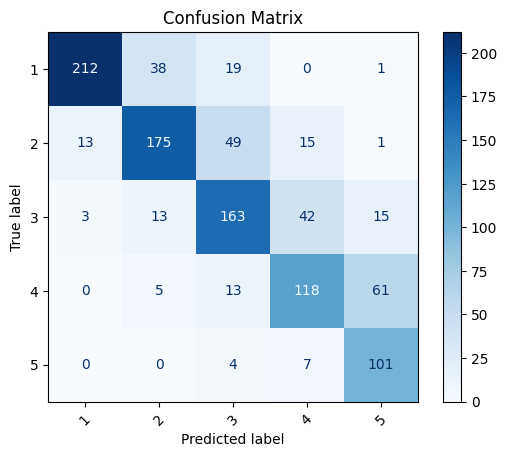


✅ 5-fold CV Accuracy: 0.6961 ± 0.0623


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


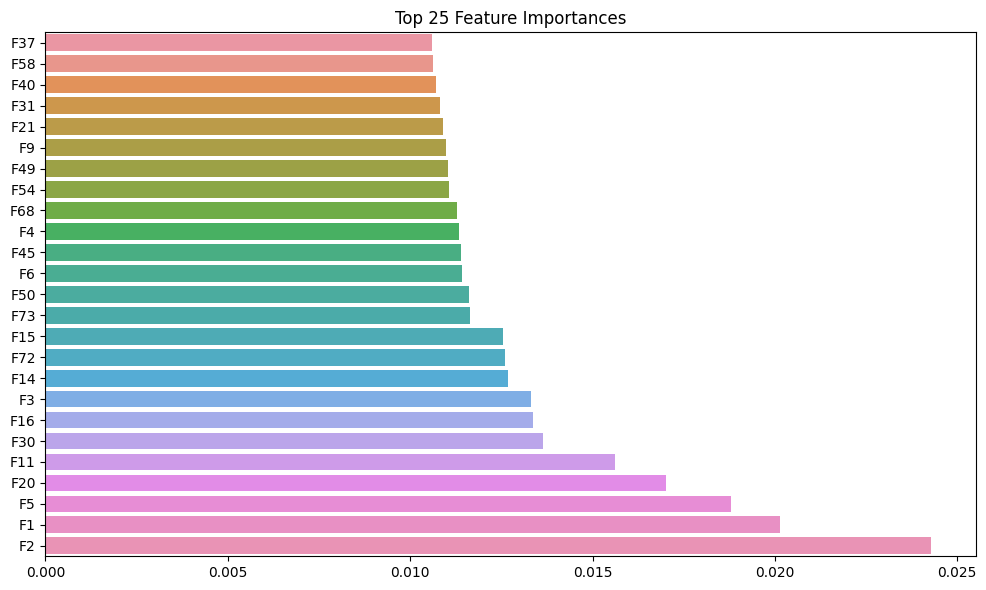

In [1]:
# === INSTALL DEPENDENCIES (if running on Kaggle/Colab) ===
!pip install -q albumentations scikit-image

# === IMPORTS ===
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.filters import sobel, gabor

import albumentations as A

# === PATHS & CONSTANTS ===
IMG_SIZE = 128
train_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/train/images'
test_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/test/images'

# === FEATURE EXTRACTION ===
def extract_features(img):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_gray = rgb2gray(img)
    img_gray_u8 = (img_gray * 255).astype(np.uint8)

    # HOG
    hog_feat = hog(img_gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(3, 3), feature_vector=True)

    # LBP
    lbp = local_binary_pattern(img_gray_u8, P=8, R=1, method='uniform')
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    hist_lbp = hist_lbp.astype("float") / (hist_lbp.sum() + 1e-7)

    # GLCM
    glcm = graycomatrix(img_gray_u8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    glcm_props = [graycoprops(glcm, prop)[0, 0] for prop in 
                  ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']]

    # Hu Moments
    hu = cv2.HuMoments(cv2.moments(img_gray_u8)).flatten()

    # Sobel
    sobel_edge = sobel(img_gray)
    sobel_hist, _ = np.histogram(sobel_edge.ravel(), bins=10, range=(0, 1))
    sobel_hist = sobel_hist.astype('float') / (sobel_hist.sum() + 1e-7)

    # Gabor
    gabor_real, _ = gabor(img_gray, frequency=0.6)
    gabor_hist, _ = np.histogram(gabor_real.ravel(), bins=10, range=(0, gabor_real.max()))
    gabor_hist = gabor_hist.astype('float') / (gabor_hist.sum() + 1e-7)

    # RGB Hist
    rgb_hist = []
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [16], [0, 256]).flatten()
        rgb_hist.extend(hist / (hist.sum() + 1e-7))

    # Color Moments
    moments = []
    for i in range(3):
        ch = img[:, :, i].flatten()
        moments.extend([np.mean(ch), np.std(ch), np.mean((ch - np.mean(ch))**3)])
    
    return np.concatenate([hog_feat, hist_lbp, glcm_props, hu, sobel_hist, gabor_hist, rgb_hist, moments])

# === LOAD DATA ===
def load_data(folder):
    paths = glob(os.path.join(folder, '*.jpg'))
    imgs, labels = [], []
    for p in paths:
        img = cv2.imread(p)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = os.path.basename(p).split("_")[-2]
        imgs.append(img)
        labels.append(label)
    return imgs, np.array(labels)

# === AUGMENTATION ===
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomGamma(p=0.3),
    A.MotionBlur(p=0.3),
    A.OneOf([A.GaussNoise(), A.ImageCompression(), A.ChannelShuffle()], p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.0, rotate_limit=0, p=0.5),
    A.CLAHE(p=0.2),
    A.HueSaturationValue(p=0.3),
    A.GridDistortion(p=0.2)
])

def augment_minority_classes(imgs, labels, augment, le):
    print("Augmenting minority classes...")
    counts = Counter(labels)
    max_count = max(counts.values())

    new_imgs, new_labels = list(imgs), list(labels)
    for cls in counts:
        cls_imgs = [x for x, y in zip(imgs, labels) if y == cls]
        for _ in range(max_count - counts[cls]):
            img = cls_imgs[np.random.randint(len(cls_imgs))]
            aug_img = augment(image=img)['image']
            new_imgs.append(aug_img)
            new_labels.append(cls)

    print("Final class distribution:", dict(Counter(new_labels)))
    feats = [extract_features(img) for img in new_imgs]
    return np.array(feats), le.transform(new_labels)

# === LOAD TRAIN & TEST ===
print("Loading training data...")
imgs_train, y_train_raw = load_data(train_img_dir)
print("Loading test data...")
imgs_test, y_test_raw = load_data(test_img_dir)

le = LabelEncoder()
le.fit(np.concatenate([y_train_raw, y_test_raw]))
y_test_enc = le.transform(y_test_raw)

# === AUGMENTATION & FEATURE EXTRACTION ===
X_train_aug, y_train_enc = augment_minority_classes(imgs_train, y_train_raw, augment, le)
X_test = np.array([extract_features(img) for img in imgs_test])

# === SCALING & PCA ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_aug)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# === CLASSIFIER ===
rf = RandomForestClassifier(n_estimators=300, max_depth=30, class_weight='balanced', random_state=42)
rf.fit(X_train_pca, y_train_enc)

# === PREDICTIONS & REPORT ===
y_pred = rf.predict(X_test_pca)

print("\n📄 Classification Report:\n")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))
print("✅ Accuracy: {:.2f}%".format(accuracy_score(y_test_enc, y_pred)*100))

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# === CROSS VALIDATION ===
scores = cross_val_score(rf, X_train_pca, y_train_enc, cv=5)
print(f"\n✅ 5-fold CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# === FEATURE IMPORTANCE ===
importances = rf.feature_importances_
top_idx = np.argsort(importances)[-25:]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[top_idx], y=[f"F{i}" for i in top_idx])
plt.title("Top 25 Feature Importances")
plt.tight_layout()
plt.show()


Loading training data...


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Loading test data...
Augmenting minority classes...
Final class distribution: {'3': 2159, '4': 2159, '1': 2159, '2': 2159, '5': 2159}

📄 Classification Report:

              precision    recall  f1-score   support

           1       0.93      0.81      0.87       270
           2       0.78      0.70      0.74       253
           3       0.68      0.71      0.69       236
           4       0.64      0.66      0.65       197
           5       0.63      0.87      0.73       112

    accuracy                           0.74      1068
   macro avg       0.73      0.75      0.74      1068
weighted avg       0.75      0.74      0.74      1068

✅ Accuracy: 74.16%


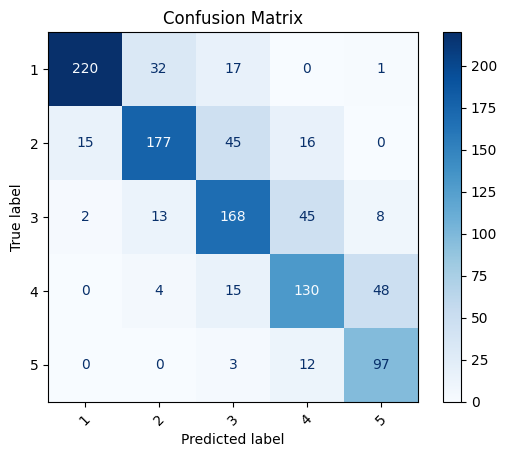


✅ 5-fold CV Accuracy: 0.6862 ± 0.0763


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


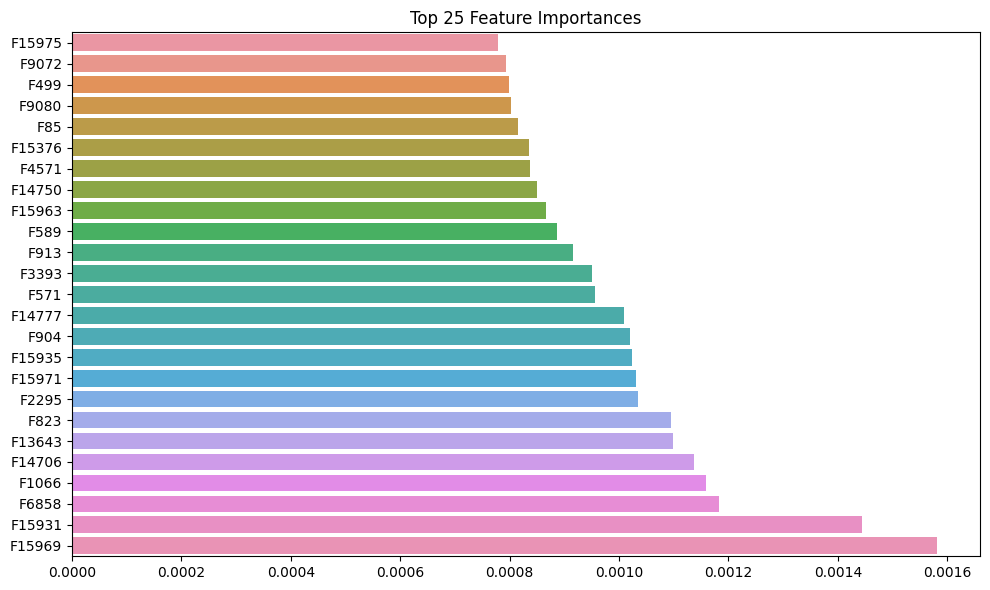

In [2]:
# === INSTALL DEPENDENCIES (if running on Kaggle/Colab) ===
!pip install -q albumentations scikit-image

# === IMPORTS ===
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.filters import sobel, gabor

import albumentations as A

# === PATHS & CONSTANTS ===
IMG_SIZE = 128
train_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/train/images'
test_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/test/images'

# === FEATURE EXTRACTION ===
def extract_features(img):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_gray = rgb2gray(img)
    img_gray_u8 = (img_gray * 255).astype(np.uint8)

    # HOG
    hog_feat = hog(img_gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(3, 3), feature_vector=True)

    # LBP
    lbp = local_binary_pattern(img_gray_u8, P=8, R=1, method='uniform')
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    hist_lbp = hist_lbp.astype("float") / (hist_lbp.sum() + 1e-7)

    # GLCM
    glcm = graycomatrix(img_gray_u8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    glcm_props = [graycoprops(glcm, prop)[0, 0] for prop in 
                  ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']]

    # Hu Moments
    hu = cv2.HuMoments(cv2.moments(img_gray_u8)).flatten()

    # Sobel
    sobel_edge = sobel(img_gray)
    sobel_hist, _ = np.histogram(sobel_edge.ravel(), bins=10, range=(0, 1))
    sobel_hist = sobel_hist.astype('float') / (sobel_hist.sum() + 1e-7)

    # Gabor
    gabor_real, _ = gabor(img_gray, frequency=0.6)
    gabor_hist, _ = np.histogram(gabor_real.ravel(), bins=10, range=(0, gabor_real.max()))
    gabor_hist = gabor_hist.astype('float') / (gabor_hist.sum() + 1e-7)

    # RGB Hist
    rgb_hist = []
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [16], [0, 256]).flatten()
        rgb_hist.extend(hist / (hist.sum() + 1e-7))

    # Color Moments
    moments = []
    for i in range(3):
        ch = img[:, :, i].flatten()
        moments.extend([np.mean(ch), np.std(ch), np.mean((ch - np.mean(ch))**3)])

    return np.concatenate([hog_feat, hist_lbp, glcm_props, hu, sobel_hist, gabor_hist, rgb_hist, moments])

# === LOAD DATA ===
def load_data(folder):
    paths = glob(os.path.join(folder, '*.jpg'))
    imgs, labels = [], []
    for p in paths:
        img = cv2.imread(p)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = os.path.basename(p).split("_")[-2]
        imgs.append(img)
        labels.append(label)
    return imgs, np.array(labels)

# === AUGMENTATION ===
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomGamma(p=0.3),
    A.MotionBlur(p=0.3),
    A.OneOf([A.GaussNoise(), A.ImageCompression(), A.ChannelShuffle()], p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.0, rotate_limit=0, p=0.5),
    A.CLAHE(p=0.2),
    A.HueSaturationValue(p=0.3),
    A.GridDistortion(p=0.2)
])

def augment_minority_classes(imgs, labels, augment, le):
    print("Augmenting minority classes...")
    counts = Counter(labels)
    max_count = max(counts.values())

    new_imgs, new_labels = list(imgs), list(labels)
    for cls in counts:
        cls_imgs = [x for x, y in zip(imgs, labels) if y == cls]
        for _ in range(max_count - counts[cls]):
            img = cls_imgs[np.random.randint(len(cls_imgs))]
            aug_img = augment(image=img)['image']
            new_imgs.append(aug_img)
            new_labels.append(cls)

    print("Final class distribution:", dict(Counter(new_labels)))
    feats = [extract_features(img) for img in new_imgs]
    return np.array(feats), le.transform(new_labels)

# === LOAD TRAIN & TEST ===
print("Loading training data...")
imgs_train, y_train_raw = load_data(train_img_dir)
print("Loading test data...")
imgs_test, y_test_raw = load_data(test_img_dir)

le = LabelEncoder()
le.fit(np.concatenate([y_train_raw, y_test_raw]))
y_test_enc = le.transform(y_test_raw)

# === AUGMENTATION & FEATURE EXTRACTION ===
X_train_aug, y_train_enc = augment_minority_classes(imgs_train, y_train_raw, augment, le)
X_test = np.array([extract_features(img) for img in imgs_test])

# === SCALING ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_aug)
X_test_scaled = scaler.transform(X_test)

# === CLASSIFIER ===
rf = RandomForestClassifier(n_estimators=300, max_depth=30, class_weight='balanced', random_state=42)
rf.fit(X_train_scaled, y_train_enc)

# === PREDICTIONS & REPORT ===
y_pred = rf.predict(X_test_scaled)

print("\n📄 Classification Report:\n")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))
print("✅ Accuracy: {:.2f}%".format(accuracy_score(y_test_enc, y_pred)*100))

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# === CROSS VALIDATION ===
scores = cross_val_score(rf, X_train_scaled, y_train_enc, cv=5)
print(f"\n✅ 5-fold CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# === FEATURE IMPORTANCE ===
importances = rf.feature_importances_
top_idx = np.argsort(importances)[-25:]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[top_idx], y=[f"F{i}" for i in top_idx])
plt.title("Top 25 Feature Importances")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Loading training data...
Loading test data...
Augmenting classes...
Final class distribution: {'3': 2426, '4': 2426, '1': 2426, '2': 2426, '5': 2426}

Initial Classification Report:

              precision    recall  f1-score   support

           1       0.92      0.81      0.86       270
           2       0.78      0.69      0.73       253
           3       0.69      0.72      0.71       236
           4       0.65      0.66      0.65       197
           5       0.62      0.86      0.72       112

    accuracy                           0.74      1068
   macro avg       0.73      0.75      0.73      1068
weighted avg       0.75      0.74      0.74      1068



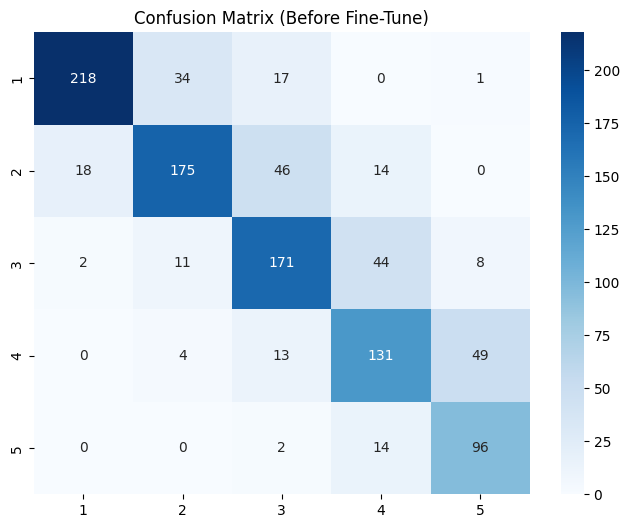

 Confused Class Indices: [0, 1, 2, 3, 4]
 Confused Class Labels: ['1', '2', '3', '4', '5']
Augmenting classes...
Final class distribution: {'3': 2426, '4': 2426, '1': 2426, '2': 2426, '5': 2426}

Final Classification Report (after fine-tuning):

              precision    recall  f1-score   support

           1       0.93      0.80      0.86       270
           2       0.78      0.69      0.74       253
           3       0.68      0.73      0.70       236
           4       0.64      0.68      0.66       197
           5       0.63      0.84      0.72       112

    accuracy                           0.74      1068
   macro avg       0.73      0.75      0.73      1068
weighted avg       0.75      0.74      0.74      1068



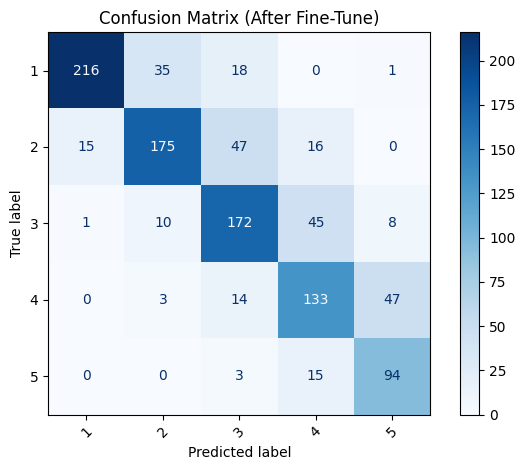

In [1]:
# === IMPORTS ===
import os, cv2, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.filters import sobel, gabor

import albumentations as A

# === CONSTANTS ===
IMG_SIZE = 128
train_img_dirs = [
    '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/train/images',
    '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/val/images'
]
test_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/test/images'

# === FEATURE EXTRACTION ===
def extract_features(img):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_gray = rgb2gray(img)
    img_gray_u8 = (img_gray * 255).astype(np.uint8)

    hog_feat = hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), feature_vector=True)
    lbp = local_binary_pattern(img_gray_u8, P=8, R=1, method='uniform')
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    hist_lbp = hist_lbp.astype(np.float32)
    hist_lbp /= (hist_lbp.sum() + 1e-7)


    glcm = graycomatrix(img_gray_u8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    glcm_props = [graycoprops(glcm, p)[0, 0] for p in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']]
    hu = cv2.HuMoments(cv2.moments(img_gray_u8)).flatten()
    sobel_edge = sobel(img_gray)
    sobel_hist, _ = np.histogram(sobel_edge.ravel(), bins=10, range=(0, 1))
    sobel_hist = sobel_hist.astype(np.float32)
    sobel_hist /= (sobel_hist.sum() + 1e-7)
    gabor_real, _ = gabor(img_gray, frequency=0.6)
    gabor_hist, _ = np.histogram(gabor_real.ravel(), bins=10, range=(0, gabor_real.max()))
    gabor_hist = gabor_hist.astype(np.float32)  # <-- Added this line
    gabor_hist /= (gabor_hist.sum() + 1e-7)


    rgb_hist = []
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [16], [0, 256]).flatten()
        rgb_hist.extend(hist / (hist.sum() + 1e-7))

    moments = []
    for i in range(3):
        ch = img[:, :, i].flatten()
        moments.extend([np.mean(ch), np.std(ch), np.mean((ch - np.mean(ch))**3)])

    return np.concatenate([hog_feat, hist_lbp, glcm_props, hu, sobel_hist, gabor_hist, rgb_hist, moments])

# === DATA LOADING ===
def load_data(folders):
    if isinstance(folders, str): folders = [folders]
    imgs, labels = [], []
    for folder in folders:
        for p in glob(os.path.join(folder, '*.jpg')):
            img = cv2.imread(p)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            label = os.path.basename(p).split("_")[-2]
            imgs.append(img)
            labels.append(label)
    return imgs, np.array(labels)

# === AUGMENTATION ===
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomGamma(p=0.3),
    A.MotionBlur(p=0.3),
    A.OneOf([A.GaussNoise(), A.ImageCompression(), A.ChannelShuffle()], p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.0, rotate_limit=0, p=0.5),
    A.CLAHE(p=0.2),
    A.HueSaturationValue(p=0.3),
    A.GridDistortion(p=0.2)
])

def augment_minority_classes(imgs, labels, augment, le, limit_to=None):
    print("Augmenting classes...")
    counts = Counter(labels)
    max_count = max(counts.values())
    new_imgs, new_labels = list(imgs), list(labels)
    for cls in counts:
        if limit_to and le.transform([cls])[0] not in limit_to:
            continue
        cls_imgs = [x for x, y in zip(imgs, labels) if y == cls]
        for _ in range(max_count - counts[cls]):
            img = cls_imgs[np.random.randint(len(cls_imgs))]
            aug_img = augment(image=img)['image']
            new_imgs.append(aug_img)
            new_labels.append(cls)
    print("Final class distribution:", dict(Counter(new_labels)))
    feats = [extract_features(img) for img in new_imgs]
    return np.array(feats), le.transform(new_labels)

# === LOAD ===
print("Loading training data...")
imgs_train, y_train_raw = load_data(train_img_dirs)
print("Loading test data...")
imgs_test, y_test_raw = load_data(test_img_dir)

le = LabelEncoder()
le.fit(np.concatenate([y_train_raw, y_test_raw]))
y_test_enc = le.transform(y_test_raw)

X_train, y_train_enc = augment_minority_classes(imgs_train, y_train_raw, augment, le)
X_test = np.array([extract_features(img) for img in imgs_test])

# === SCALE ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === MODEL ===
rf = RandomForestClassifier(n_estimators=300, max_depth=30, class_weight='balanced', random_state=42)
rf.fit(X_train_scaled, y_train_enc)

# === INITIAL EVAL ===
y_pred = rf.predict(X_test_scaled)
print("\nInitial Classification Report:\n")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

# === CONFUSION MATRIX + CONFUSED PAIRS ===
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Before Fine-Tune)")
plt.show()

confused_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i][j] >= 10:
            confused_pairs.append((i, j))

confused_classes = sorted(set(i for pair in confused_pairs for i in pair))
print(" Confused Class Indices:", confused_classes)
print(" Confused Class Labels:", [le.classes_[i] for i in confused_classes])

# === RE-AUGMENT ONLY CONFUSED CLASSES & RETRAIN ===
X_train_conf, y_train_conf = augment_minority_classes(imgs_train, y_train_raw, augment, le, limit_to=confused_classes)
X_train_conf_scaled = scaler.fit_transform(X_train_conf)

X_train_comb = np.concatenate([X_train_scaled, X_train_conf])
y_train_comb = np.concatenate([y_train_enc, y_train_conf])

scaler = StandardScaler()
X_train_comb_scaled = scaler.fit_transform(X_train_comb)
X_test_scaled = scaler.transform(X_test)

rf.fit(X_train_comb_scaled, y_train_comb)

y_pred_final = rf.predict(X_test_scaled)

print("\nFinal Classification Report (after fine-tuning):\n")
print(classification_report(y_test_enc, y_pred_final, target_names=le.classes_))

# === FINAL CONFUSION MATRIX ===
cm2 = confusion_matrix(y_test_enc, y_pred_final)
ConfusionMatrixDisplay(cm2, display_labels=le.classes_).plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (After Fine-Tune)")
plt.tight_layout()
plt.show()
